# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [3]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import os

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2015 from the CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [5]:
year = "2015"
years = [2015]

# Ensure the directory exists
os.makedirs(f"models/{year}", exist_ok=True)

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 314770


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [7]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
66697,20150322113320PD,5701925,5/13/2021 12:00:00 AM,P150810408,2,3/22/2015 12:00:00 AM,3/22/2015 12:00:00 AM,11:09:22,415,DISTURBANCE,N,No report required; dispatch r,[400]-[500] W VIRGINIA ST,San Jose,CA,37.320040,-121.894092,Gardner
267465,20151103034630PS,5996526,5/13/2021 12:00:00 AM,P153070069,3,11/3/2015 12:00:00 AM,11/3/2015 12:00:00 AM,02:59:41,1091C,INJURED ANIMAL,N,No report required; dispatch r,SILVER CREEK VALLEY RD & FARNS,San Jose,CA,37.295956,-121.785046,Silver Creek Country Club
62296,20150317152041PD,5695386,5/13/2021 12:00:00 AM,P150760605,2,3/17/2015 12:00:00 AM,3/17/2015 12:00:00 AM,15:04:51,415,DISTURBANCE,N,No report required; dispatch r,[5800]-[5900] WINFIELD BL,San Jose,CA,NaN,NaN,NaN
8822,20150112101923PS,5614804,5/13/2021 12:00:00 AM,P150120264,5,1/12/2015 12:00:00 AM,1/12/2015 12:00:00 AM,10:05:46,601T,TRUANT (TABS),A,Arrest Made,N JACKSON AV & MABURY RD,San Jose,CA,37.379817,-121.854253,Penitencia Creek
288986,20151129181133PS,6029009,5/13/2021 12:00:00 AM,P153330622,5,11/29/2015 12:00:00 AM,11/29/2015 12:00:00 AM,18:04:49,1154,SUSPICIOUS VEHICLE,N,No report required; dispatch r,GLENFIELD DR & FAIRGLEN DR,San Jose,CA,37.277938,-121.902023,Briarwood


In [8]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314770 entries, 0 to 314769
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              314770 non-null  object 
 1   EID               314770 non-null  int64  
 2   START_DATE        314770 non-null  object 
 3   CALL_NUMBER       314770 non-null  object 
 4   PRIORITY          314770 non-null  int64  
 5   REPORT_DATE       314770 non-null  object 
 6   OFFENSE_DATE      314770 non-null  object 
 7   OFFENSE_TIME      314770 non-null  object 
 8   CALLTYPE_CODE     314770 non-null  object 
 9   CALL_TYPE         314728 non-null  object 
 10  FINAL_DISPO_CODE  314770 non-null  object 
 11  FINAL_DISPO       314770 non-null  object 
 12  ADDRESS           303128 non-null  object 
 13  CITY              314770 non-null  object 
 14  STATE             314770 non-null  object 
 15  LATITUDE          281224 non-null  float64
 16  LONGITUDE         28

In [9]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.147700e+05,314770.000000,281224.000000,281224.000000
mean,5.835607e+06,3.198577,37.319835,-121.869622
std,1.338672e+05,1.328254,0.044172,0.048534
min,5.601416e+06,1.000000,34.009821,-122.035696
25%,5.719814e+06,2.000000,37.294701,-121.900710
50%,5.836604e+06,3.000000,37.323754,-121.866346
75%,5.950793e+06,4.000000,37.348796,-121.836549
max,6.067929e+06,6.000000,37.534539,-117.909022


In [10]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,314770,314770,314770,314770,314770,314770,314770,314728,314770,314770,303128,314770,314770,279706
unique,311913,1,304184,365,365,80754,217,211,22,18,32246,1,1,295
top,20150129192630PS,5/13/2021 12:00:00 AM,P151400087,7/4/2015 12:00:00 AM,7/4/2015 12:00:00 AM,18:54:04,415,DISTURBANCE,N,No report required; dispatch r,Not a valid geographical locat,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,314770,6,1305,1305,20,30946,30945,123147,123147,1867,314770,314770,7839


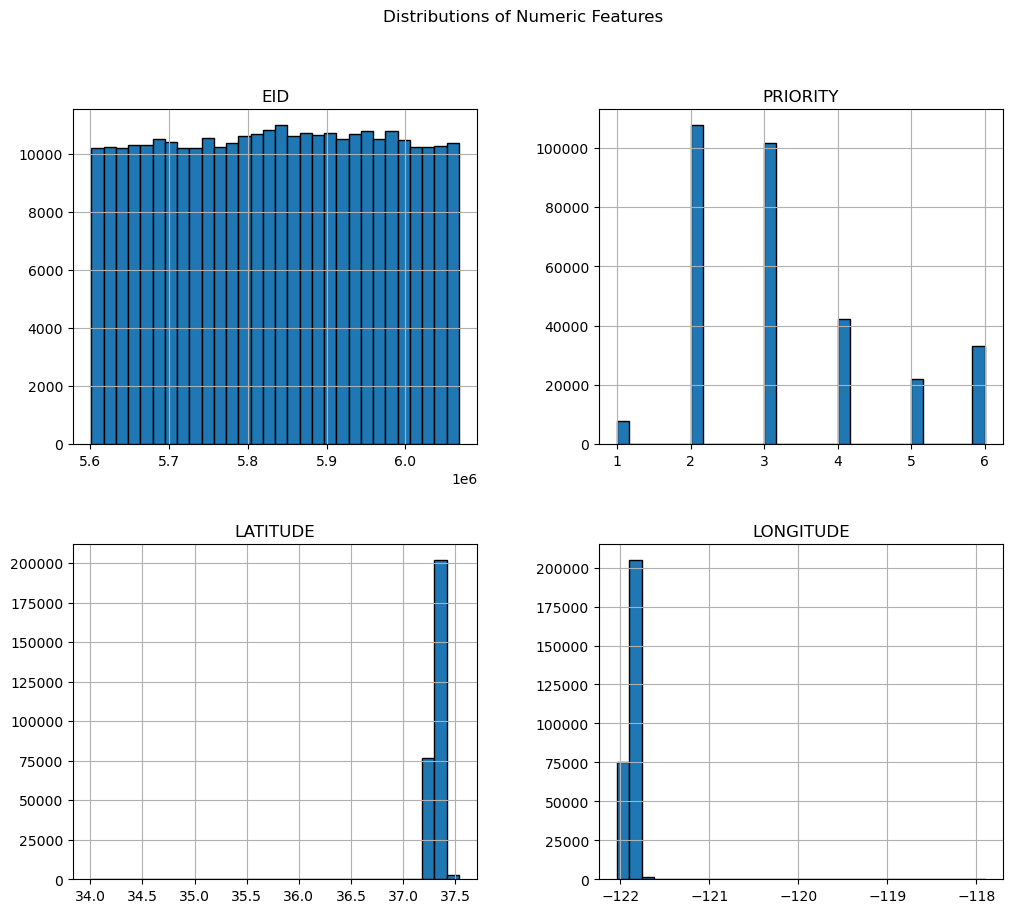

In [11]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [12]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE              42
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS             11642
CITY                    0
STATE                   0
LATITUDE            33546
LONGITUDE           33546
neighborhood        35064
dtype: int64

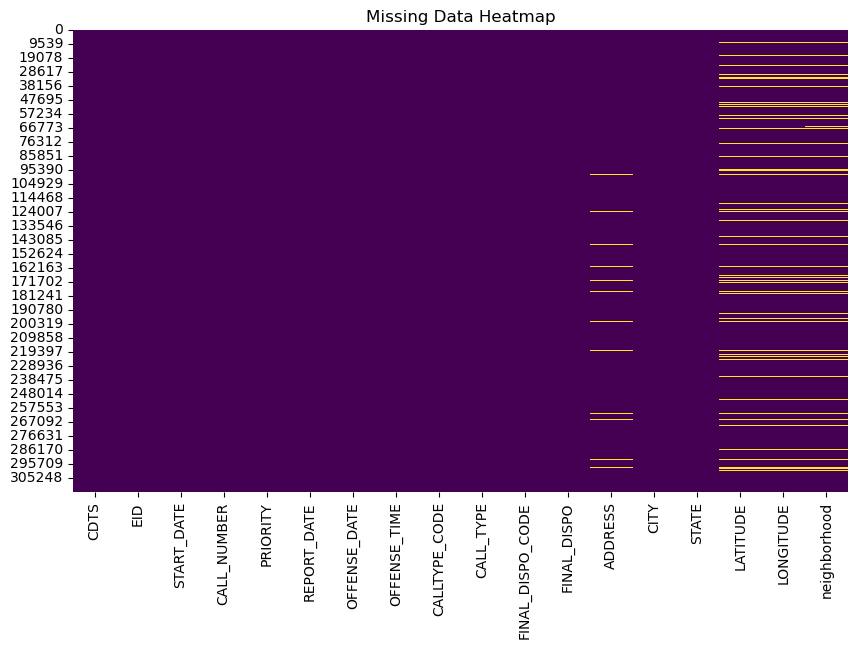

In [13]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [14]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 311913 unique values
START_DATE: 1 unique values
CALL_NUMBER: 304184 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 80754 unique values
CALLTYPE_CODE: 217 unique values
CALL_TYPE: 211 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 32246 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [16]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      7839
Little Saigon and Spring Brook    5319
Five Wounds-San Jose High         4251
Trimble Business Area             4225
Steinbeck and Allen               4187
                                  ... 
San Jose Country Club               47
Linda Vista and Hillcrest           39
Alta Vista                          38
Meadowlands                         33
Santa Teresa Hills                  28
Name: count, Length: 295, dtype: int64

In [17]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          123147
CAN         58511
R           34254
NR          22568
G           18550
A            7570
GD           6827
E            6733
ADV          5926
DUPNCAN      5874
H            5304
C            4144
B            3279
T            3245
O            3111
D            2963
U            1776
F             772
M             114
P              84
TOT            15
Z               3
Name: count, dtype: int64

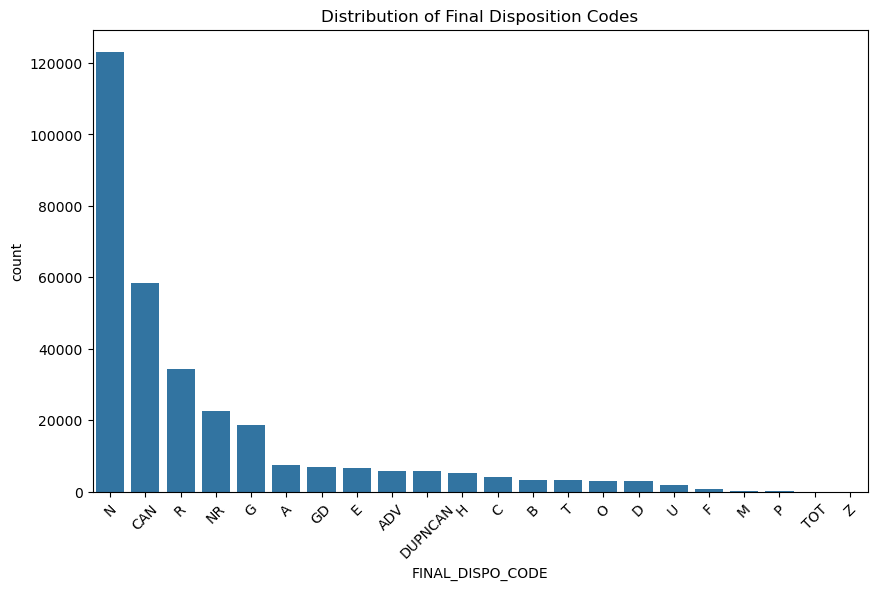

In [18]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [21]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    123147
Canceled                           58511
Report taken                       34254
No Response                        22568
No Disposition                     18645
Gone on Arrival/unable to loca     18550
Arrest Made                         7570
Traffic Citation Issued, Non-H      6733
Courtesy Service/Citizen or ag      5304
Criminal Citation                   4144
Arrest by Warrant                   3279
Turned over To (TOT)                3245
Supplemental report taken           3111
Traffic Citation Issued, Hazar      2963
Unfounded event                     1776
Field Interview (F.I.) Complet       772
Stranded motorist assist             114
Prior case, follow-up activity        84
Name: count, dtype: int64

In [24]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'CAN': 'Canceled',
 'N': 'No report required; dispatch r',
 'E': 'Traffic Citation Issued, Non-H',
 'NR': 'No Response',
 'GD': 'No Disposition',
 'R': 'Report taken',
 'G': 'Gone on Arrival/unable to loca',
 'T': 'Turned over To (TOT)',
 'A': 'Arrest Made',
 'DUPNCAN': 'No Disposition',
 'B': 'Arrest by Warrant',
 'O': 'Supplemental report taken',
 'C': 'Criminal Citation',
 'ADV': 'No Disposition',
 'U': 'Unfounded event',
 'D': 'Traffic Citation Issued, Hazar',
 'H': 'Courtesy Service/Citizen or ag',
 'M': 'Stranded motorist assist',
 'F': 'Field Interview (F.I.) Complet',
 'TOT': 'No Disposition',
 'P': 'Prior case, follow-up activity',
 'Z': 'No Disposition'}

In [25]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'1182': 'VEHICLE ACCIDENT, PROPERTY DAM',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '22500': 'PARKING VIOLATION',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 'WELCK': 'WELFARE CHECK',
 '1070': 'PROWLER',
 '1033A': 'ALARM, AUDIBLE',
 '1053': 'PERSON DOWN',
 '459': 'BURGLARY (460)',
 '415': 'DISTURBANCE',
 '415M': 'DISTURBANCE, MUSIC',
 '415F': 'DISTURBANCE, FAMILY',
 '1062': 'MEET THE CITIZEN',
 '245': 'ASSAULT WITH DEADLY WEAPON',
 '647B': 'SOLICITING FOR PROSTITUTION',
 '23152': 'MISDEMEANOR DUI',
 '1057': 'FIREARMS DISCHARGED',
 '415FEMS': 'DISTURBANCE, FAMILY (COMBINED ',
 '459R': 'BURGLARY  REPORT  (460)',
 '1095': 'PEDESTRIAN STOP',
 'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 '1195': 'VEHICLE STOP',
 '1154': 'SUSPICIOUS VEHICLE',
 '1055': 'CORONERS CASE',
 '415A': 'DISTURBANCE, FIGHT',
 '459VEH': 'VEHICLE BURGLARY',
 '911VOIP': 'UNK TYPE 911 CALL FROM VOIP TE',
 '422': 'CRIMINAL THREATS',
 '417': 'BRANDISHING A WEAPON',
 '1066': 'SUSPICIOUS PERSON',
 '415W': 'DISTURBANCE, WEAPON',
 '20002

## Focus on Target Dispositions

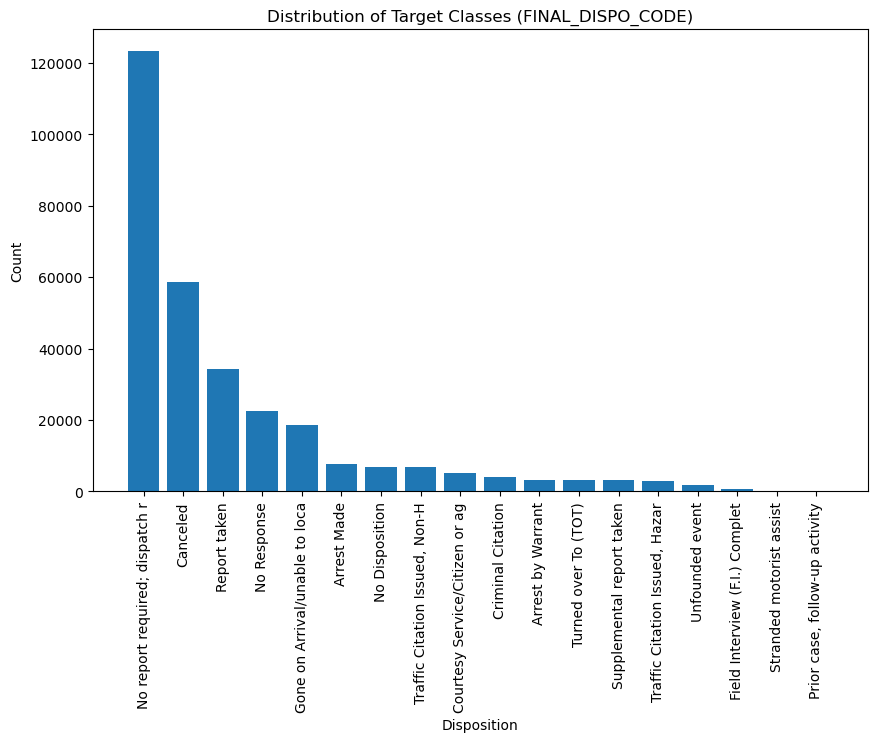

In [29]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [31]:
model_utils.transform_offense_date(all_police_df)

In [32]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    299777
A          7570
C          4144
B          3279
Name: count, dtype: int64

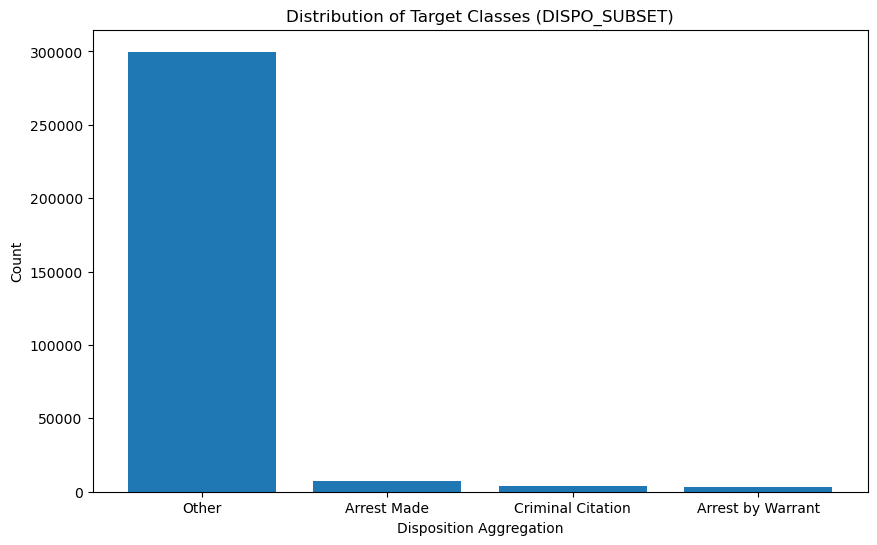

In [33]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [35]:
encoder = joblib.load('one_hot_encoder.pkl')

In [36]:
police_calls_encoded, _ = model_utils.clean_and_transform_data(all_police_df, encoder)
police_calls_encoded.shape

Police Calls Dataset: 314770 rows before cleaning, 279670 rows after cleaning.


(279670, 535)

## Define X and Y

In [38]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled = \
    model_utils.split_data(police_calls_encoded, dispo_mapping)

classes = ['A' 'B' 'C' 'Other']
(223736, 534)
(55934, 534)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 213084, 0: 5413, 2: 2907, 1: 2332})
Counter({3: 10652, 0: 5413, 2: 2907, 1: 2332})


y_train distribution: Counter({3: 213084, 0: 5413, 2: 2907, 1: 2332})
y_test distribution: Counter({3: 53271, 0: 1353, 2: 727, 1: 583})
y_train_resampled distribution: Counter({3: 213084, 0: 5413, 2: 2907, 1: 2332})


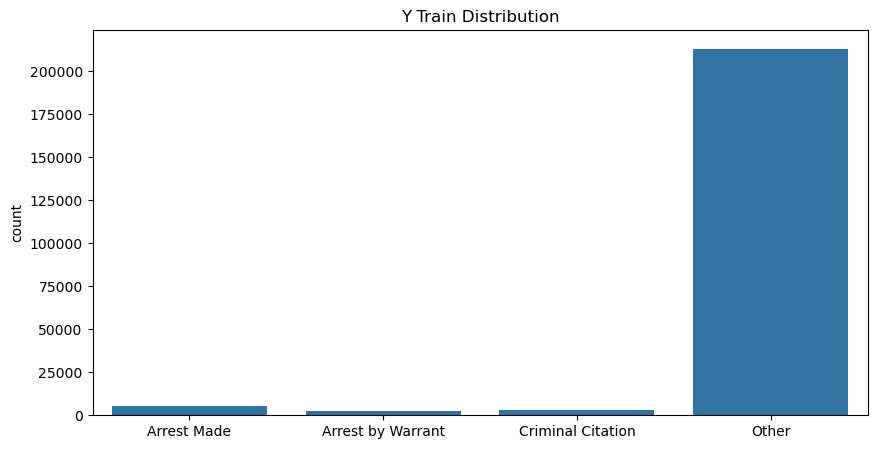

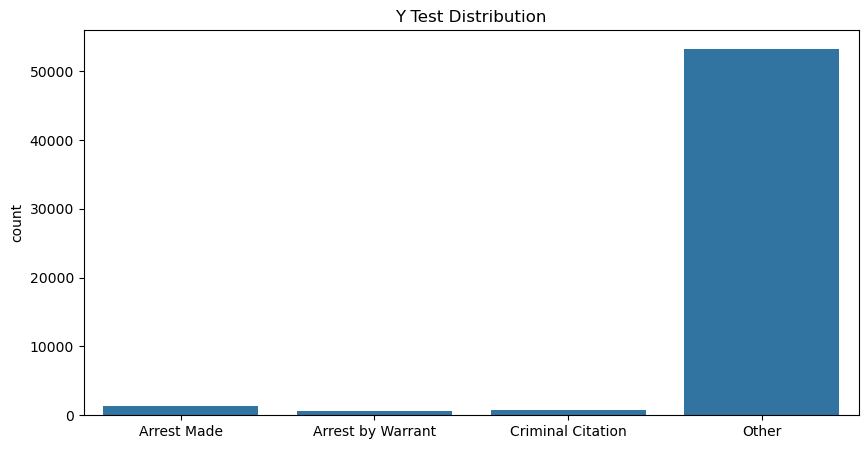

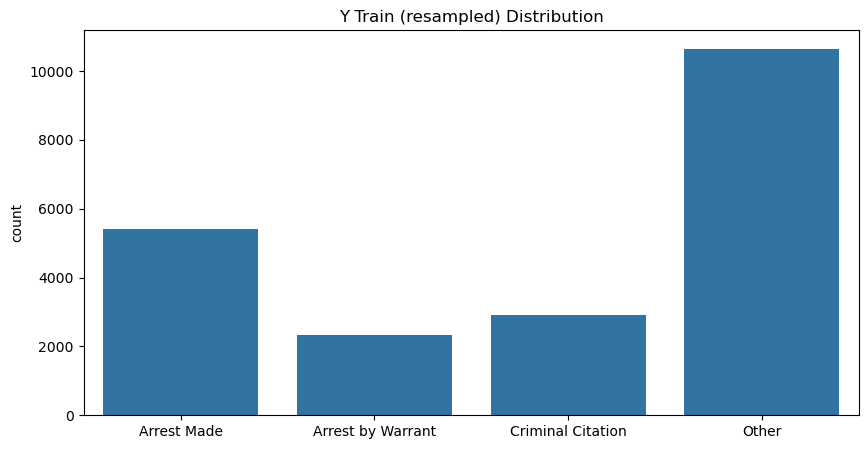

In [40]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [50]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [54]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [57]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      1353
Arrest by Warrant       0.00      0.00      0.00       583
Criminal Citation       0.00      0.00      0.00       727
            Other       0.95      1.00      0.98     53271

         accuracy                           0.95     55934
        macro avg       0.24      0.25      0.24     55934
     weighted avg       0.91      0.95      0.93     55934



### Logistic Regression

In [59]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [60]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [61]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.24      0.73      0.36      1353
Arrest by Warrant       0.51      0.71      0.59       583
Criminal Citation       0.18      0.56      0.28       727
            Other       0.99      0.91      0.95     53271

         accuracy                           0.89     55934
        macro avg       0.48      0.73      0.54     55934
     weighted avg       0.95      0.89      0.92     55934



#### Hyperparameter Tuning

In [64]:
grid_search_scoring_method = 'f1_macro'

In [65]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

# Initialize Grid Search
# make sure n_jobs is reasonable so my machine doesn't run out of memory
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=3, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=3, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [66]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 0.1}
Best Score (f1_macro): 0.6163


In [67]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2015/best_logistic_regression.pkl']

In [68]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [69]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.67      0.43      0.52      1353
Arrest by Warrant       0.80      0.69      0.74       583
Criminal Citation       0.60      0.19      0.29       727
            Other       0.97      0.99      0.98     53271

         accuracy                           0.97     55934
        macro avg       0.76      0.57      0.63     55934
     weighted avg       0.96      0.97      0.96     55934



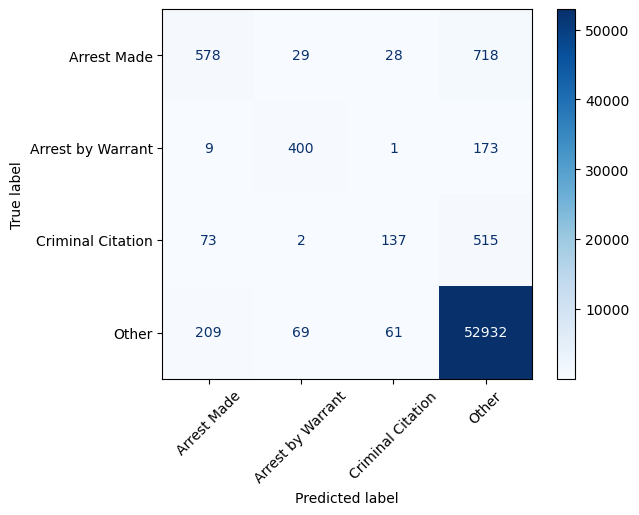

In [70]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [73]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [75]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [79]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                           Feature  Importance  \
189                             CALLTYPE_CODE_601T    0.007927   
205                               CALLTYPE_CODE_6M    0.006466   
204                               CALLTYPE_CODE_6F    0.003606   
170                              CALLTYPE_CODE_484    0.003308   
112                            CALLTYPE_CODE_23152    0.001877   
64                             CALLTYPE_CODE_11300    0.001848   
69                             CALLTYPE_CODE_11377    0.001758   
72                             CALLTYPE_CODE_11550    0.001520   
89                             CALLTYPE_CODE_14601    0.001430   
119                              CALLTYPE_CODE_242    0.001252   
201                             CALLTYPE_CODE_647F    0.001043   
85                             CALLTYPE_CODE_12020    0.000983   
49                            CALLTYPE_CODE_10851R    0.000894   
13                             CALLTYPE_CODE_1033A    0.000834   
180       

In [80]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                  Display Name  Coefficient
189                   Call Type: TRUANT (TABS)     0.365998
49         Call Type: RECOVERED STOLEN VEHICLE     0.344389
13                   Call Type: ALARM, AUDIBLE    -0.337636
107               Call Type: PARKING VIOLATION    -0.309898
112                 Call Type: MISDEMEANOR DUI     0.300778
180       Call Type: MENTALLY DISTURBED PERSON     0.258249
153              Call Type: DISTURBANCE, MUSIC    -0.191418
47                   Call Type: STOLEN VEHICLE     0.179095
209     Call Type: UNK TYPE 911 CALL FROM CELL    -0.177708
201                 Call Type: DRUNK IN PUBLIC     0.168323
165                  Call Type: BURGLARY (460)     0.158607
63                   Call Type: TRAFFIC HAZARD    -0.151904
69          Call Type: POSSESSION OF NARCOTICS     0.149751
204                     Call Type: FELONY WANT     0.142051
103              Call Type: STRONG ARM ROBBERY     0.141441
64                 

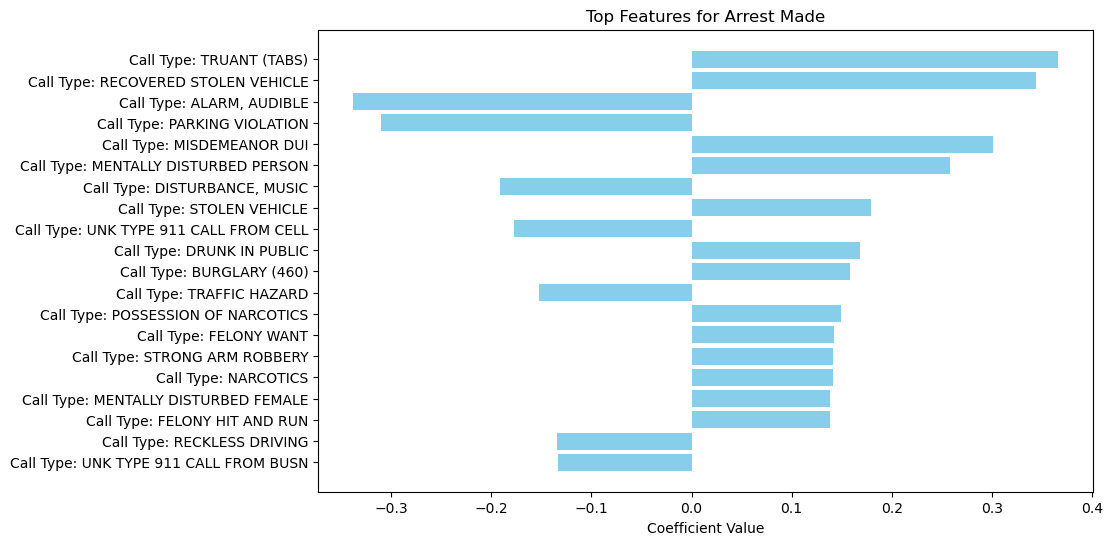

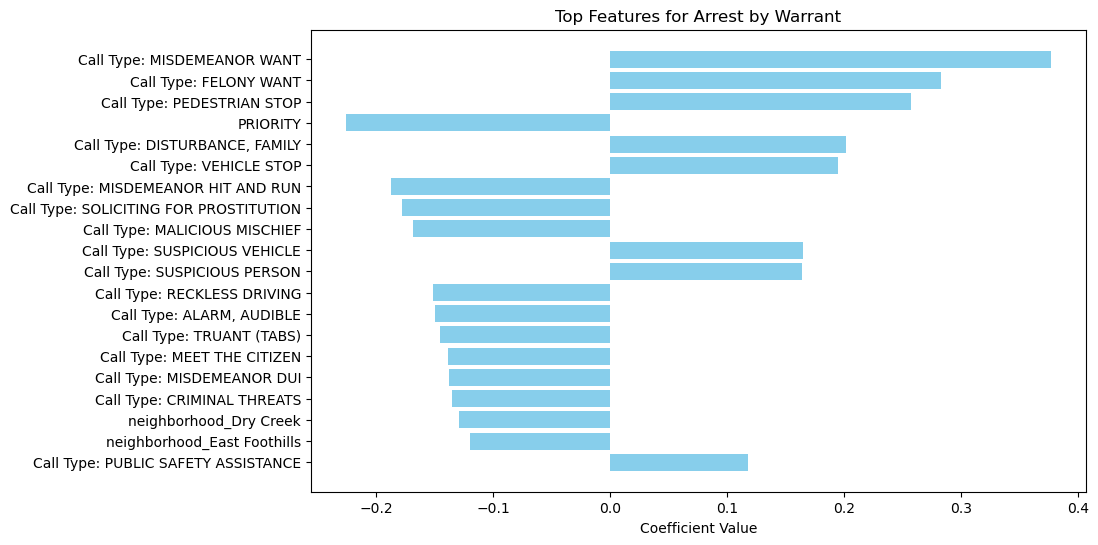

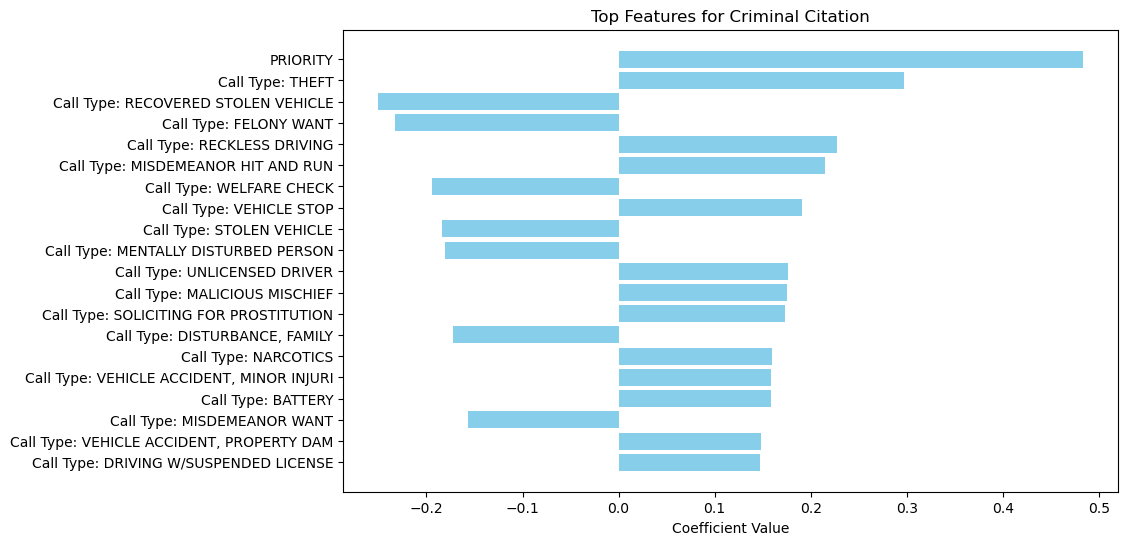

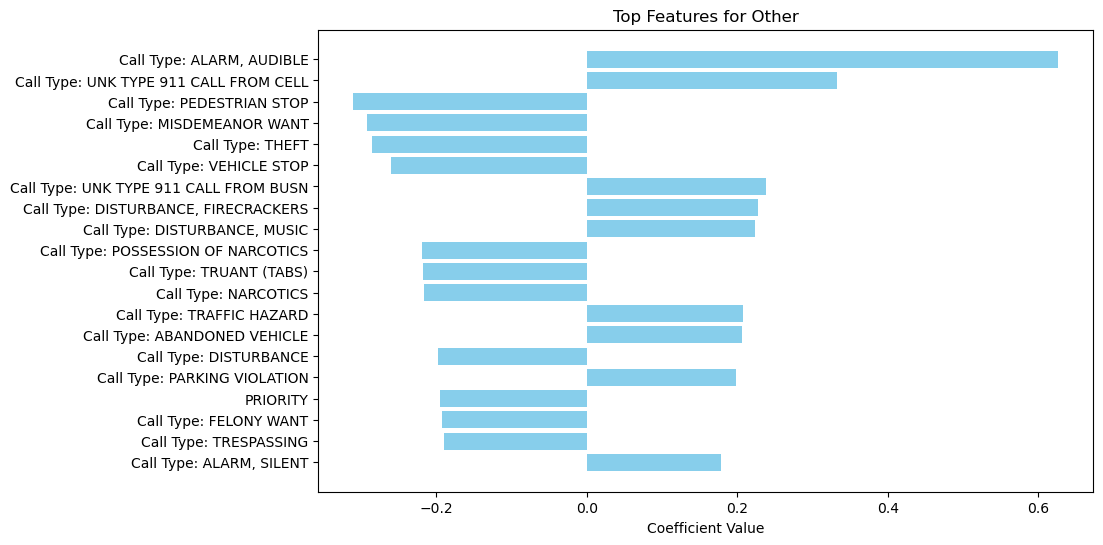

In [81]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [83]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [84]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.65      0.45      0.54      1353
Arrest by Warrant       0.76      0.67      0.71       583
Criminal Citation       0.46      0.27      0.34       727
            Other       0.98      0.99      0.98     53271

         accuracy                           0.96     55934
        macro avg       0.71      0.60      0.64     55934
     weighted avg       0.96      0.96      0.96     55934



#### Hyperparameter Tuning and Cross Validation

In [86]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=5,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 60}
Best Score (f1_macro): 0.63


In [87]:
best_rf = grid_rf.best_estimator_

In [88]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2015/best_random_forest.pkl']

In [89]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [90]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.64      0.44      0.52      1353
Arrest by Warrant       0.76      0.66      0.71       583
Criminal Citation       0.48      0.26      0.34       727
            Other       0.98      0.99      0.98     53271

         accuracy                           0.96     55934
        macro avg       0.72      0.59      0.64     55934
     weighted avg       0.96      0.96      0.96     55934



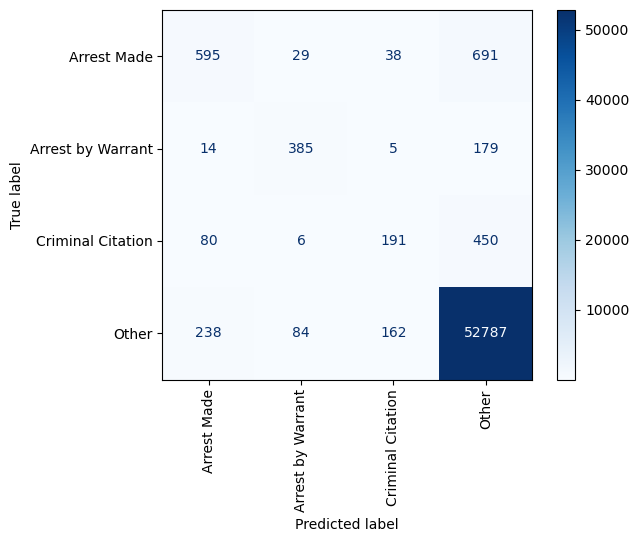

In [91]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

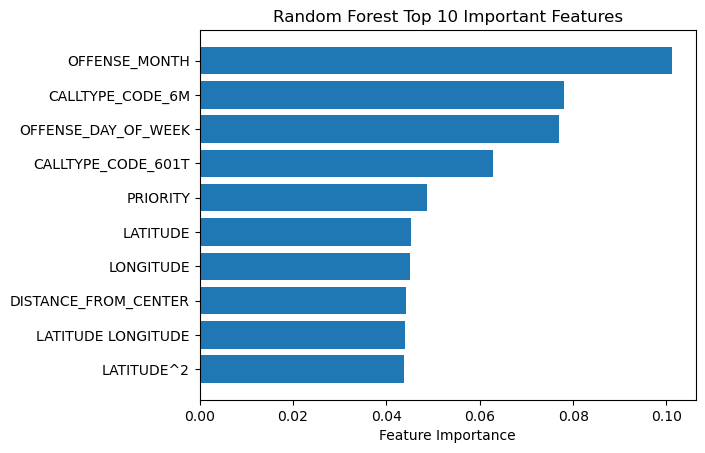

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Top 10 Important Features')
plt.show()

### Multilayer Perceptron Model

In [95]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [96]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=5,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [97]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [98]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9558 - loss: 0.1875 - val_accuracy: 0.9661 - val_loss: 0.1238
Epoch 2/20
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9632 - loss: 0.1334 - val_accuracy: 0.9659 - val_loss: 0.1273
Epoch 3/20
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9644 - loss: 0.1264 - val_accuracy: 0.9665 - val_loss: 0.1238
Epoch 4/20
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9653 - loss: 0.1214 - val_accuracy: 0.9661 - val_loss: 0.1244
Epoch 5/20
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9652 - loss: 0.1216 - val_accuracy: 0.9668 - val_loss: 0.1240
Epoch 6/20
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9669 - loss: 0.1150 - val_accuracy: 0.9665 - val_loss: 0.1272
Epoch 7/20
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9672 - loss: 0.1116 - val_accuracy: 0.9664 - val_loss: 0.1279
Epoch 8/20
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9673 - loss: 0.1094 - 

In [99]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2015/mlp_model.pkl']

In [100]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [101]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.9657 - loss: 0.1254
Test Accuracy: 0.9654


In [102]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.66      0.42      0.52      1353
Arrest by Warrant       0.80      0.67      0.73       583
Criminal Citation       0.62      0.14      0.23       727
            Other       0.97      0.99      0.98     53271

         accuracy                           0.97     55934
        macro avg       0.76      0.56      0.61     55934
     weighted avg       0.96      0.97      0.96     55934



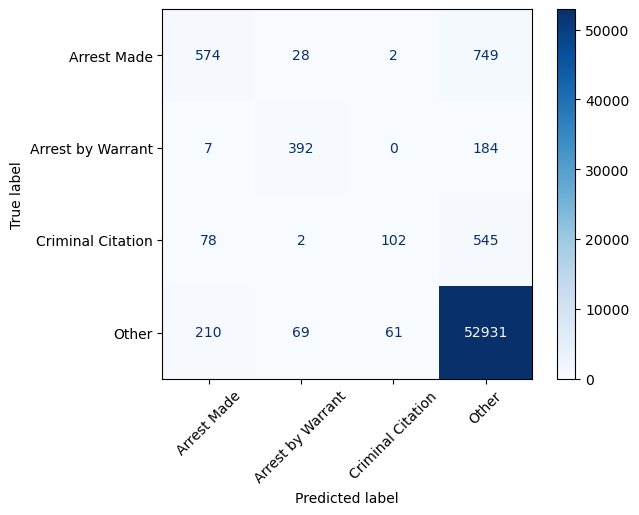

In [103]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [106]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-04 09:27:51,721] A new study created in memory with name: no-name-be2d0e53-e131-43f5-84de-d560442d87d7
[I 2024-10-04 09:28:47,029] Trial 0 finished with value: 0.7400291797432119 and parameters: {'n_estimators': 492, 'learning_rate': 0.013608144202129089, 'max_depth': 12, 'subsample': 0.9426827097832614, 'colsample_bytree': 0.9301612854710918, 'gamma': 0.006374401260543557, 'reg_alpha': 0.0017579025713042478, 'reg_lambda': 0.0003502434589197798}. Best is trial 0 with value: 0.7400291797432119.
[I 2024-10-04 09:29:15,695] Trial 1 finished with value: 0.6864449923633665 and parameters: {'n_estimators': 446, 'learning_rate': 0.0018794362483427554, 'max_depth': 6, 'subsample': 0.9210579038493589, 'colsample_bytree': 0.8348906846309038, 'gamma': 0.48099502235751057, 'reg_alpha': 0.002580334076137069, 'reg_lambda': 0.006405024111368414}. Best is trial 0 with value: 0.7400291797432119.
[I 2024-10-04 09:29:43,099] Trial 2 finished with value: 0.7461372441649148 and parameters: {'n_e

Actual runtime: 471.73 seconds (7.86 minutes)
Best parameters found:  {'n_estimators': 218, 'learning_rate': 0.07590857838312848, 'max_depth': 9, 'subsample': 0.6851285079126204, 'colsample_bytree': 0.7297380864875105, 'gamma': 0.005255263634293748, 'reg_alpha': 0.6321652473136201, 'reg_lambda': 2.953189661754431e-08}
Best F1 macro score:  0.7466495074925869


In [107]:
# Train the final model with the best parameters:
best_params = study.best_params
best_model = XGBClassifier(**best_params, eval_metric='logloss')
best_model.fit(X_train, y_train)
xgb_1_model = best_model
xgb_1_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7297380864875105, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.005255263634293748, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07590857838312848, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=218, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [108]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.68      0.48      0.56      1353
Arrest by Warrant       0.80      0.67      0.73       583
Criminal Citation       0.54      0.24      0.33       727
            Other       0.98      0.99      0.98     53271

         accuracy                           0.97     55934
        macro avg       0.75      0.60      0.65     55934
     weighted avg       0.96      0.97      0.96     55934



In [109]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2015/xgb_model.pkl']

In [112]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [116]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [117]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.6324841192058839
RF F1: 0.6384153281815621
XGB F1: 0.6529935280224065


In [118]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

#### Stacking #1

In [120]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=5)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7297380864875105,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,...
                                              learning_rate=0.07590857838312848,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=9,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=218, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(), n_jobs=5)

In [121]:
joblib.dump(stacking_clf, f"models/{year}/stacking_1.pkl") 

['models/2015/stacking_1.pkl']

In [122]:
stacking_clf = joblib.load(f"models/{year}/stacking_1.pkl")

In [123]:
y_pred_stacking_1 = stacking_clf.predict(X_test)
stack_1_accuracy = accuracy_score(y_test, y_pred_stacking_1)
stack_1_recall = recall_score(y_test, y_pred_stacking_1, average='macro')
stack_1_prec = precision_score(y_test, y_pred_stacking_1, average='macro')
stack_1_f1 = f1_score(y_test, y_pred_stacking_1, average='macro')
print(f"Stacking Classifier F1 Score: {stack_1_f1}")

Stacking Classifier F1 Score: 0.656350576768726


#### Stacking #2

In [125]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=5)
stacking_clf_2.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7297380864875105,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=5)

In [126]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2015/stacking_2.pkl']

In [127]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [128]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.6654382622060759


## Results

In [130]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Stack 1', 'Stack 2'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.952390,0.250000,0.238098,0.243904
Logistic Regression,0.966264,0.573847,0.760695,0.632484
Random Forest,0.964673,0.588445,0.715918,0.638415
MLP,0.965406,0.557637,0.762479,0.614612
XGB,0.967390,0.596021,0.751294,0.652994
Stack 1,0.967640,0.595239,0.760842,0.656351
Stack 2,0.968016,0.613565,0.756722,0.665438


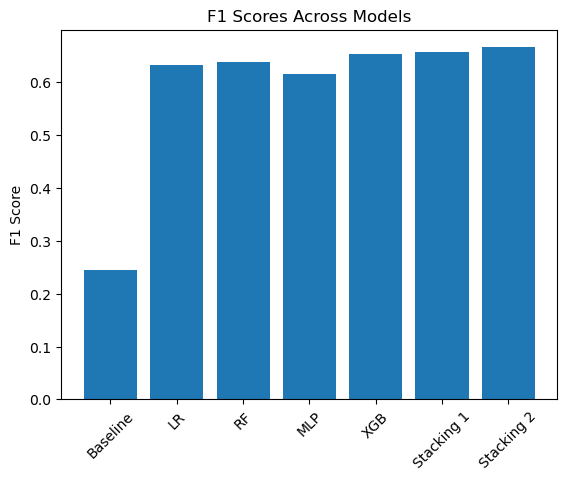

In [131]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Stacking 1', 'Stacking 2']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Compare with the All-Year Models

In [183]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [184]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

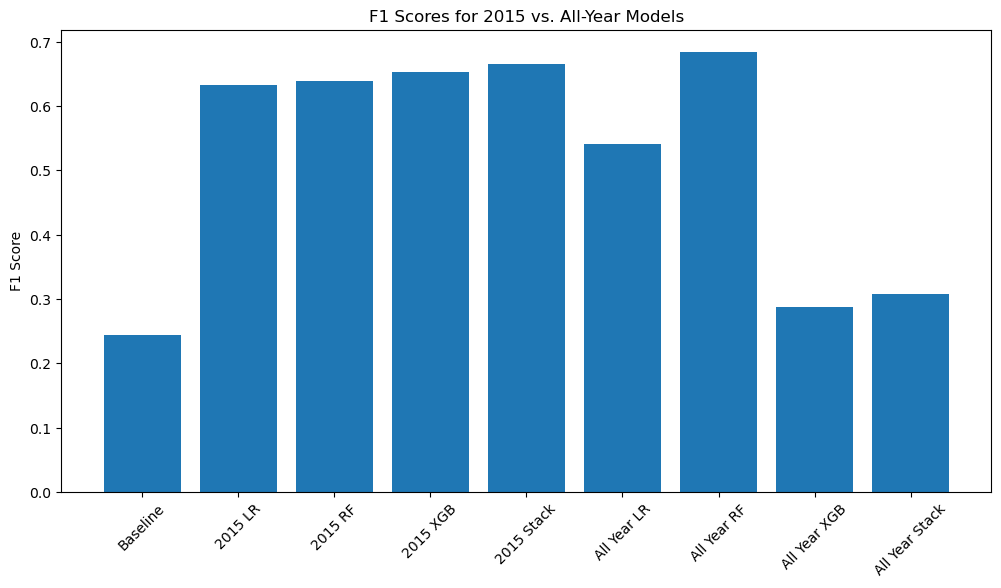

In [190]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()